In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import os
import numpy as np
import pandas as pd
import pickle
from scipy.sparse import csr_matrix, hstack, vstack
from functools import lru_cache
import json
from tqdm import tqdm_notebook, tnrange
import itertools
import re

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, Ridge
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.base import BaseEstimator
from sklearn.ensemble import BaggingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_absolute_error

In [2]:
RAND = 123
PATH_TO_DATA = 'data/'
PATH_TO_SUBMIT = 'submissions/'
PATH_TO_TEST_JSON = os.path.join(PATH_TO_DATA, 'test.json')
PATH_TO_TRAIN_JSON = os.path.join(PATH_TO_DATA, 'train.json')

In [3]:
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

In [4]:
def write_to_submission_file(prediction, filename):
    submission = pd.read_csv(os.path.join(PATH_TO_DATA, 'sample_submission.csv'), 
                             index_col='id')
    submission['log_recommends'] = prediction
    submission.to_csv(os.path.join(PATH_TO_SUBMIT, filename))
    
def submit(model, X, y, transformers=None, test_name=None, name='submit'):
    for ind in range(1, 1000):
        name_with_ind = name + '_' + str(ind)
        if name_with_ind not in os.listdir(PATH_TO_SUBMIT):
            name = name_with_ind
            break
    print(name)
    
    model.fit(X, preproc(y))
    predict = predict_from_file(model, transformers, test_name)
    write_to_submission_file(predict, name)
    log(X=X, model=model, status='submit {}'.format(name))
    return predict

In [5]:
def predict_from_file(model, transformers, file_name):
    time = pd.read_csv(os.path.join(PATH_TO_DATA, 'time_test (1).csv'), index_col=0)
    content = pd.read_csv(os.path.join(PATH_TO_DATA, 'content_test (1).csv'), index_col=0)
    test_df = pd.concat((time,content), axis=1)
    test_df = test_df.drop(set(test_df.columns) & set(bad_names), axis=1)
    
    for name in pred_gen_names:
        if name not in test_df.columns:
            test_df[name] = np.zeros(len(test_df))
    
    """for ind, data in tqdm_notebook(enumerate(read_iter(file_name))):
        df = pd.concat((pd.DataFrame([data], index=[ind]), 
                        test_df.iloc[ind:ind+1]), axis=1)
        display(df)
        display(extract_pred_gen(df))
        features = generate_all_features(df, transformers=transformers)[0]
        
        asd()"""
    return [postproc(
                model.predict(
                    generate_all_features(pd.concat((pd.DataFrame([data], index=[ind]), 
                                                     test_df.iloc[ind:ind+1]), axis=1), 
                                          transformers=transformers)[0]
                )[0]
            )
            for ind, data in enumerate(read_iter(file_name))]

In [6]:
def read_json_line(line=None):
    result = None
    try:        
        result = json.loads(line)
    except Exception as e:
        idx_to_replace = int(str(e).split(' ')[-1].replace(')',''))     
        new_line = list(line)
        new_line[idx_to_replace] = ' '
        new_line = ''.join(new_line)     
        return read_json_line(line=new_line)
    return result

In [7]:
def extract_info(line):
    return {
        #'text': line['content'],
        #'timestamp': line['_timestamp'],
        'content': line['content'],
        'text': strip_tags(line['content'] \
                           .replace('\n', ' ') \
                           .replace('\r', ' ')),
        #'image_url': line['image_url'],
        'description': line['meta_tags']['description'],
        'title': line['title'],
        'date': pd.to_datetime(line['published']['$date']),
        'author_url': line['author']['url'],
        'author_twitter': line['author']['twitter'],
        'url': line['url'],
        'id': line['_id']
    }


def read_iter(path_to_inp_json_file, count=None):
    if count is None:
        with open(path_to_inp_json_file) as fl:
            count = sum(1 for line in fl)
    with open(path_to_inp_json_file, encoding='utf-8') as inp_file:
        for line in tqdm_notebook(itertools.islice(inp_file, count), total=count):
            yield extract_info(read_json_line(line))

            
def read_all(path_to_inp_json_file, count=None):
    return pd.DataFrame(read_iter(path_to_inp_json_file, count))

In [8]:
train_text_df = read_all(PATH_TO_TRAIN_JSON, count=10000)

A Jupyter Widget

In [28]:
train_time = pd.read_csv(os.path.join(PATH_TO_DATA, 'time (1).csv'), index_col=0)
train_content = pd.read_csv(os.path.join(PATH_TO_DATA, 'content (1).csv'), index_col=0)

train_df = pd.concat((train_time,train_content, train_text_df), axis=1)
train_df = train_df.iloc[train_text_df.index]

In [29]:
train_df['target'] = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_log1p_recommends.csv'), 
                                 index_col='id')['log_recommends'].values[:train_df.shape[0]]
train_df = train_df.sort_values(by='date')
train_df = train_df[train_df['date'].apply(lambda x: x.year >= 2014)]
y = train_df['target']
train_df = train_df.drop('target', axis=1)
len(train_df)

9840

In [30]:
bad_names = [name for name in train_df.columns if name.startswith('year') 
                                                 or name.startswith('day')
                                                 or name.startswith('month')
                                                 or name.startswith('weekday')] + \
            ['published', 'second', 'hour', 'commas', 'minute', 'questions', 'cos_time', 'sin_time', 'sentences']
train_df = train_df.drop(bad_names, axis=1)
pred_gen_names = list(set(train_df.columns) - set(train_text_df.columns))
train_df.head(3)

,sat_or_thu,exclamations,gifs,images,author_twitter,author_url,content,date,description,id,text,title,url
8759,0,6,0,4,@chrismessina,https://medium.com/@chrismessina,"<div><header class=""container u-maxWidth740""><...",2014-01-03 01:14:17.632,"For the first time in 10 years, since I moved ...",https://medium.com/chris-messina/funemployed-1...,"Chris MessinaCo-founder of Molly. Product guy,...",Funemployed! – Chris Messina – Medium,https://medium.com/chris-messina/funemployed-1...
2280,0,2,0,4,@jrlevine,https://medium.com/@jrlevine,"<div><header class=""container u-maxWidth740""><...",2014-01-03 19:15:40.291,I hear it again and again: “I’m done with soft...,https://medium.com/the-frontier/remember-the-f...,Jake LevineFounder & CEO @electricobjects http...,Remember The Frontier – The Frontier – Medium,https://medium.com/the-frontier/remember-the-f...
4575,0,7,0,10,@mecolalu,https://medium.com/@mecolalu,"<div><header class=""container u-maxWidth740""><...",2014-01-03 21:02:58.055,"Ali, and I sold Peanut Labs about 3 years ago....",https://medium.com/@mecolalu/how-we-did-15-sta...,Murtaza HussainBuilder of things and ideas.Jan...,How we did 15 startups in 21 months – Murtaza ...,https://medium.com/@mecolalu/how-we-did-15-sta...


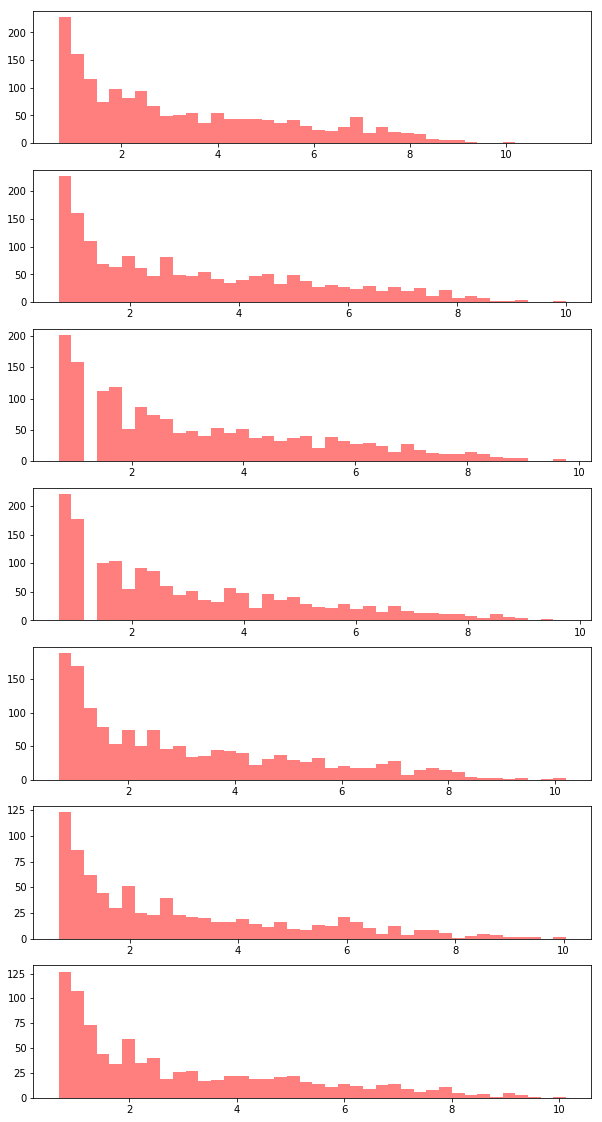

In [24]:
plt.figure(1, figsize=(10, 20))

for i in range(7):
    plt.subplot(10*71 + i + 1)
    name = 'weekday_{}'.format(i)
    plt.hist(y[train_df[name] == 1], bins=40, alpha=.5, color='red');

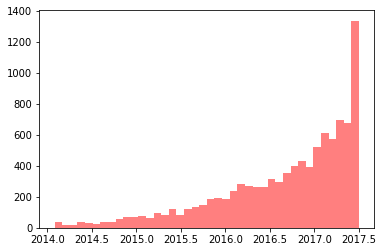

In [31]:
plt.hist(train_df['date'].apply(lambda x: x.year + x.month / 12), 
         bins=40, alpha=.5, color='red', label='true');

In [32]:
pred_gen_names

['sat_or_thu', 'exclamations', 'images', 'gifs']

In [40]:
def load_tfidf():#'TF.pickle'
    with open(os.path.join(PATH_TO_DATA, 'TFIDF_DUMP (1)'), 'rb') as fl:
        return pickle.load(fl)

    
def extract_text(data):
    return data['title'] + ' ' + data['text']


def generate_text_features(data):
    text = data['title'] + ' ' + data['text']
    features = pd.DataFrame(index=data.index)
    return features
    
    
    features['space'] = text.apply(lambda x: np.log1p(x.count(' ')))
    features['len'] = text.apply(lambda x: np.log1p(len(x)))
    features['sentences'] = text.apply(lambda x: np.log1p(x.count('.')))
    features['mean_sent'] = features['len'] / features['sentences']
    features['mean_space_sent'] = features['space'] / features['sentences']
    features['title_len'] = data['title'].apply(lambda x: np.log1p(len(x)))
    features['title_words'] = data['title'].apply(lambda x: np.log1p(x.count(' ')))
    return features
    
    
def extract_pred_gen(data):
    features = pd.DataFrame(index=data.index)
    return features
    return data[pred_gen_names]


def generate_authors(data):
    return data['author_url'].apply(lambda x: x.split('/')[-1])

def one_hot_smooth_encode(val, max_val):
    result = np.zeros(max_val)
    ival = int(val)
    result[ival] += 1 - (val - ival)
    result[(ival + 1) % max_val] += (val - ival)
    return pd.Series(result)

def encode_time(data, smooth=3, max_time=24, prefix=''):
    max_val = (max_time + smooth - 1) // smooth
    
    def encode(x):
        return one_hot_smooth_encode(x / smooth, max_val)
    
    result = data.apply(encode)
    result = result.rename(columns={ind: prefix + str(ind) 
                                    for ind in range(max_val)})
    return result


def generate_time_features(data):
    date = data['date']
    
    hours = date.apply(lambda x: x.hour + x.minute / 60)
    smooth_hours = 2
    features = pd.DataFrame(index=data.index)
    return features


    features = pd.concat([features, 
                          encode_time(hours, 
                                      prefix='smooth{}_hours_'.format(smooth_hours), 
                                      smooth=smooth_hours)], axis=1)
    for i in range(7):
        features['day_{}'.format(i)] = date.apply(lambda x: 1 if x.weekday == i else 0)
        
    features['time'] = date.apply(lambda x: np.log(x.year * 10000 + x.month * 100 + x.day))
    return features


def generate_all_features(data, y=None, transformers=None, X_test=None):
    description = ''
    
    X_text = extract_text(data)
    X_text_features = generate_text_features(data)
    X_time = generate_time_features(data)
    X_pred_gen = extract_pred_gen(data)
    
    
    if not transformers:
        transformers = {}
    
    #authors = generate_authors(data)
    #if 'vecorizer_authors' not in transformers:
    #    transformers['vecorizer_authors'] = TfidfVectorizer().fit(authors)
    #    del transformers['vecorizer_authors'].stop_words_
    #authors_csr = transformers['vecorizer_authors'].transform(authors).astype('float32')
    #description += '{}: {}\n'.format('vecorizer_authors', transformers['vecorizer_authors'])
    
    
    if 'norm_index' not in transformers:
        dif = X_pred_gen.max() - X_pred_gen.min()
        transformers['norm_index'] = X_pred_gen.columns[dif <= 3]
        transformers['unorm_index'] = X_pred_gen.columns[dif > 3]
        
    X_norm = X_pred_gen[transformers['norm_index']]
    X_unnorm = X_pred_gen[transformers['unorm_index']]
    
    
    if 'vecorizer' not in transformers:
        transformers['vecorizer'] = load_tfidf()
    X_text_csr = transformers['vecorizer'].transform(X_text).astype('float32')
    description += '{}: {}\n'.format('vecorizer', transformers['vecorizer'])
    
    
    
    #if 'trans' not in transformers:
    #    transformers['trans'] = TfidfTransformer().fit(X_norm)
    #X_norm_data = transformers['trans'].transform(X_norm)
    #description += '{}: {}\n'.format('trans', transformers['trans'])
    X_norm_data = X_norm
    
    
    to_scale = np.hstack((X_unnorm.values, X_text_features.values, X_time.values))
    
    
    #if 'scaler' not in transformers:
    #    transformers['scaler'] = StandardScaler().fit(to_scale)
    #to_scale_csr = csr_matrix(transformers['scaler'].transform(to_scale))
    #description += '{}: {}\n'.format('scaler', transformers['scaler'])
    to_scale_csr = csr_matrix(to_scale)
    
    result = hstack((X_norm_data, to_scale_csr, X_text_csr)).tocsc()
    
    
    if 'scaler2' not in transformers:
        transformers['scaler2'] = StandardScaler(with_mean=False).fit(result)
    transformers['scaler2'].partial_fit(result)
    result = csr_matrix(transformers['scaler2'].transform(result))
    description += '{}: {}\n'.format('scaler2', transformers['scaler2'])
    
    
    result.DESCRIPTION = description
    result.ANOTATION = []
    
    result.ANOTATION += (X_norm.columns + '_norm').tolist()
    result.ANOTATION += X_unnorm.columns.tolist()
    result.ANOTATION += X_text_features.columns.tolist()
    result.ANOTATION += X_time.columns.tolist()
    
    return result, transformers

In [41]:
def log(file_name='temp_results.txt', last_action_file_name='last_action.txt',
        X=None, model=None, score=None, status=None):
    log_str = 'Status: {}\n'.format(status)
    
    if score is not None:
        log_str += 'Score = {}\n\n'.format(score)
        
    if model is not None:
        log_str += 'Model:\n{}\n\n'.format(model)
        
    if X is not None:
        log_str += 'Features:\n{}\n'.format(X.DESCRIPTION)
    
    with open(file_name, 'a') as fl:
        fl.write('-'*100 + '\n');
        fl.write(log_str)
    
    with open(last_action_file_name, 'w') as fl:
        fl.write(log_str)
        
    return log_str

def preproc(y):
    return y;
    return np.log(y)

def postproc(y):
    return y;
    return np.exp(y)

def score(model, X, y, X_test, y_test, write_log=True):
    model.fit(X, preproc(y))
    
    predict = postproc(model.predict(X_test))
    mae = mean_absolute_error(y_test, predict)
    
    if write_log:
        log(model=model, 
            score=mae, 
            status='score', 
            X=X)
        
    return mae


def cross_score(model, X, y, n_splits=8, n_test=3, margin=1, write_log=True):
    l = len(y) // n_splits
    
    mae = np.array([score(model, 
                          X[i*l:(i+n_test)*l], y[i*l:(i+n_test)*l],
                          X[(i+n_test+margin)*l:], y[(i+n_test+margin)*l:],
                          write_log=False)
                    for i in tnrange(n_splits - n_test - margin)])
    
    if write_log:
        log(model=model, 
            score=mae,
            status='score my fold: {}'.format((n_splits, n_test)), 
            X=X)
        
    return mae


def cross_score2(model, X, y, n_splits=8, n_test=3, margin=1, write_log=True):
    l = len(y) // n_splits
    
    mae = np.array([score(model, 
                          X[:(i+n_test)*l], y[:(i+n_test)*l],
                          X[(i+n_test+margin)*l:], y[(i+n_test+margin)*l:],
                          write_log=False)
                    for i in tnrange(n_splits - n_test - margin)])
    
    if write_log:
        log(model=model, 
            score=mae,
            status='score my fold: {}'.format((n_splits, n_test)), 
            X=X)
        
    return mae

In [42]:
%%time
X, transformers = generate_all_features(train_df, y=y)

CPU times: user 40.8 s, sys: 660 ms, total: 41.5 s
Wall time: 41.8 s


In [43]:
last_score = last_best_score = 1.36785032052
last_score = last_best_score = 1.3243159901

In [44]:
model = Ridge(alpha=0.1, random_state=RAND)

In [46]:
%%time
arr_score = cross_score2(model, X, y, n_splits=7, n_test=3, margin=0)

new_score = arr_score.mean()
print(new_score)
print(arr_score)

print('Diff with last: {}'.format(new_score - last_score))
print('Diff with best: {}'.format(new_score - last_best_score))
last_score = new_score
if last_best_score > new_score:
    last_best_score = new_score

A Jupyter Widget


1.40035864222
[ 1.46652961  1.4104558   1.37269532  1.35175383]
Diff with last: -0.0014128058099407426
Diff with best: 0.07604265211977634
CPU times: user 2min 44s, sys: 532 ms, total: 2min 45s
Wall time: 2min 45s


In [28]:
1.63406577673
[ 1.68124614  1.65651625  1.62821288  1.57028785]

SyntaxError: invalid syntax (<ipython-input-28-5d723a2a28a2>, line 2)

In [86]:
%%time
model.fit(X, preproc(y))

CPU times: user 1min 29s, sys: 132 ms, total: 1min 29s
Wall time: 1min 29s


Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=123, solver='auto', tol=0.001)

In [39]:
anot = X.ANOTATION
n_features = len(anot)
coef = model.coef_
abs_coef = np.abs(coef)
argsort_coef = np.argsort(abs_coef[:n_features])
for ind in argsort_coef[::-1]:
    print('{:7.3f} {} '.format(coef[ind], 
                               anot[ind]))
np.sort(abs_coef)[-10:]

 -0.014 title_len 
 -0.013 mean_space_sent 
 -0.009 mean_sent 
  0.006 images 
 -0.006 title_words 
  0.006 sentences 
  0.004 gifs 
 -0.003 len 
 -0.003 exclamations 
  0.000 space 
  0.000 sat_or_thu_norm 


array([ 0.01086592,  0.0108884 ,  0.01186714,  0.01221403,  0.01277993,
        0.01435545,  0.01724106,  0.01772091,  0.02332722,  0.04488717])

In [55]:
train_X, test_X, train_y, test_y = train_test_split(X, y, shuffle=False)

In [ ]:
model.fit(train_X, preproc(train_y))

In [ ]:
test_predict = postproc(model.predict(test_X))

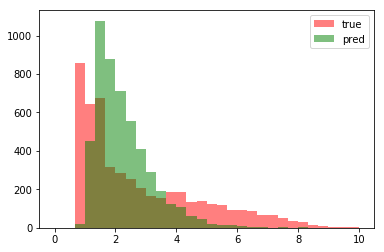

In [57]:
plt.hist(test_y, bins=30, alpha=.5, color='red', label='true', range=(0,10));
plt.hist(test_predict, bins=30, alpha=.5, color='green', label='pred', range=(0,10));
plt.legend();

In [39]:
mean_test = 4.33328
test_count = 34645
total = mean_test * 34645

In [87]:
predict = predict_from_file(model, transformers, PATH_TO_TEST_JSON)

A Jupyter Widget

KeyboardInterrupt: 

In [28]:
predict = np.array(predict)
n_predict = predict.copy()
display(n_predict.mean())
for i in range(5):
    n_predict[n_predict < 0.69315] = 0.69315
    n_predict = n_predict - n_predict.mean() + 4.333
    #n_predict = n_predict / n_predict.mean() * 4.333
n_predict.mean()

3.050781122566502

4.3330000000000002

In [29]:
2.6481973705144402

2.64819737051444

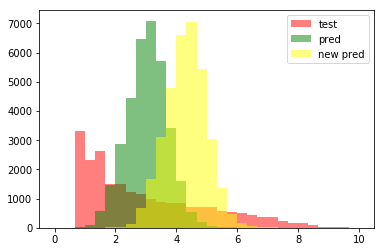

In [30]:
plt.hist(y, bins=30, alpha=.5, color='red', label='test', range=(0,10))
plt.hist(predict, bins=30, alpha=.5, color='green', label='pred', range=(0,10))
plt.hist(n_predict, bins=30, alpha=.5, color='yellow', label='new pred', range=(0,10))
plt.legend();

In [31]:
write_to_submission_file(n_predict, 'Lol')